In [1]:
# Importazione delle librerie
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import mplhep as hep
from cycler import cycler
import matplotlib.colors as colors
import multiprocessing.pool
from scipy.optimize import approx_fprime
import pandas as pd

In [228]:
# Definizione delle funzioni
def retta(x, a, b):
    return a + b*x

def fit_nl_Tf(x, ft):
    return 1/np.sqrt(1 + (x/ft)**2)

def fit_nl_phi(x, ft):
    return np.arctan((x)/ft)

In [3]:
# Impostazioni grafici
plt.style.use(hep.style.ROOT)
params = {'legend.fontsize': '12',
         'legend.loc': 'upper right',
          'legend.frameon':       'True',
          'legend.framealpha':    '0.8',      # legend patch transparency
          'legend.facecolor':     'w', # inherit from axes.facecolor; or color spec
          'legend.edgecolor':     'w',      # background patch boundary color
          'figure.figsize': (6, 4),
         'axes.labelsize': '12',
         'figure.titlesize' : '16',
         'axes.titlesize':'14',
         'xtick.labelsize':'12',
         'ytick.labelsize':'12',
         'lines.linewidth': '1',
         'text.usetex': True,
#         'axes.formatter.limits': '-5, -3',
         'axes.formatter.min_exponent': '2',
#         'axes.prop_cycle': cycler('color', 'bgrcmyk')
         'figure.subplot.left':'0.125',
         'figure.subplot.bottom':'0.125',
         'figure.subplot.right':'0.925',
         'figure.subplot.top':'0.925',
         'figure.subplot.wspace':'0.1',
         'figure.subplot.hspace':'0.1',
#         'figure.constrained_layout.use' : True
          }
plt.rcParams.update(params)
plt.rcParams['axes.prop_cycle'] = cycler(color=['b','g','r','c','m','y','k'])

In [75]:
# Importazione dei dati per fit globale
data = pd.read_csv('Dati.txt', sep="\t")

# I file devono essere formattati in questo modo:
# f	Vch2	sV	dT	sT
# con f [Hz], Vch2[V], sV[V], dT[us], sT[us]
# - f, frequenze in ingresso
# - Vch2, Ampiezza misurata ai capi della resistenza
# - sV, scala  della misura 
# - 

f = data["f"]
phi = 2e-6 * np.pi * data["f"] * data["dT"] # in rapporto a 90°
sphi = 2e-6 * np.pi * data["f"] * np.sqrt(data["sT"]/(10*6**0.5))

Vin = 8.16 # V
sVin = np.sqrt((0.3*Vin/(24**0.5))**2+(1/(25*24**0.5)))

Tf = data["Vch2"]/Vin
sTf = np.sqrt((0.3*data["Vch2"]/(24**0.5))**2+(1/(25*24**0.5)) + (data["Vch2"]/Vin * sVin)**2)/Vin # Assumo triangolare



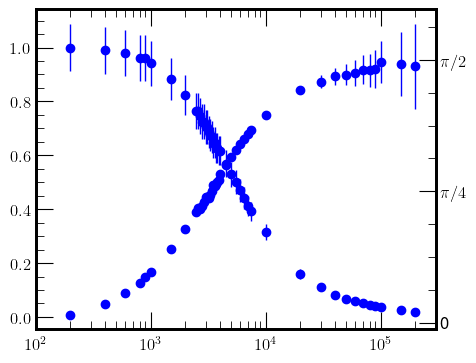

In [76]:
# Plot dei dati importati
fig, axA = plt.subplots(1,1, figsize=(5,4))
axA.errorbar(f, Tf, yerr=sTf , fmt='o')
axA.semilogx()
axF = axA.twinx()

axF.set_yticks((0, np.pi/4, np.pi/2))
labels = axF.set_yticklabels(('0', r'$\pi / 4$', r'$\pi / 2$'))

axF.errorbar(f, phi,  yerr= sphi, xerr=sphi , fmt='o')

axA.set_xlim(100,max(f)+10**5)

plt.show()

[3208.36740516] [[100.80480111]]
0.07425484161727194


[]

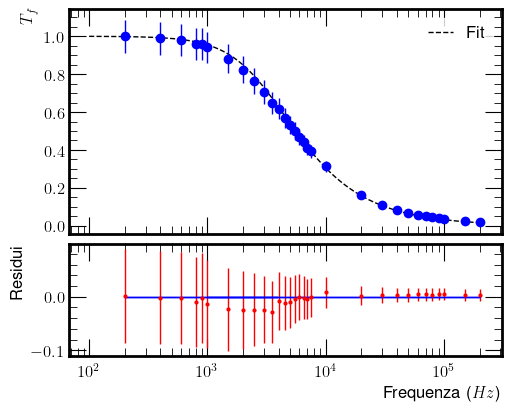

In [ ]:
# Fit della funzione di trasferimento non lineare
valtr, covtr = curve_fit(fit_nl_Tf, f, Tf, p0=[3142], method='lm' ,sigma=sTf, absolute_sigma=True)
print(valtr, covtr**0.5)

resTr = Tf - fit_nl_Tf(f, *valtr)
chi2Tf = np.sum((resTr/sTf)**2)
print(chi2Tf/(len(f)-1))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_nl_Tf(x_fit, *valtr), label='Fit', linestyle='--', color='black')
ax[0].errorbar(f, Tf, yerr=sTf , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$T_f$')

ax[1].errorbar(f,resTr,yerr=sTf, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))

ax[0].semilogx()
# AAAAA

[3271.18879402] [[10.06046026]]
5.24207921425766


[]

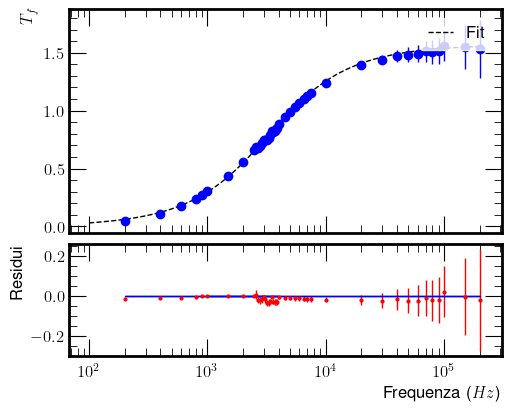

In [227]:
# Fit della fase non lineare
valphi, covphi = curve_fit(fit_nl_phi, f, phi, p0=[3106], method='lm' ,sigma=sphi, absolute_sigma=True)
print(valphi, covphi**0.5)

resPhi = phi - fit_nl_phi(f, *valtr)
chi2phi = np.sum((resPhi/sphi)**2)

print(chi2phi/(len(f)-1))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_nl_phi(x_fit, *valphi), label='Fit', linestyle='--', color='black')

ax[0].errorbar(f, phi, yerr=sphi, fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$T_f$')

ax[1].errorbar(f,resPhi,yerr=sphi, fmt='o', label='Residui',ms=2,color='red')

ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))

ax[0].semilogx()


In [222]:
# Fit di Bode
valbode, covbode = curve_fit(retta, np.log10(f[f > 6e3]), 20*np.log10(Tf[f > 6e3]), method='lm' ,sigma=sTf[f > 6e3]/Tf[f > 6e3], absolute_sigma=True)

residuBode = Tf[f>3] - 10**(retta(np.log10(f[f > 6e3]), *valbode)/20)
chi2bode = np.sum((residuBode/sTf[f > 6e3])**2)

print(chi2bode/(len(sTf[f > 6e3])-2))

print(valbode, '\n' , np.sqrt(np.diag(covbode)), '\n' , covbode) # Se voglio vedere i -20 dB su decade basta moltiplicare questo per 20

log_ftbode = (-valbode[0]/valbode[1])
slog_ftbode = log_ftbode * (covbode[0,0]/valbode[0]**2 + covbode[1,1]/valbode[1]**2 - 2*covbode[1,0]/(valbode[0]*valbode[1]))**0.5

print(round(10**log_ftbode), '+/-', round(10**(slog_ftbode+log_ftbode)-10**log_ftbode))

0.020449166574411173
[ 62.96541075 -18.34520463] 
 [0.39523201 0.09477731] 
 [[ 0.15620834 -0.03730162]
 [-0.03730162  0.00898274]]
2706 +/- 26


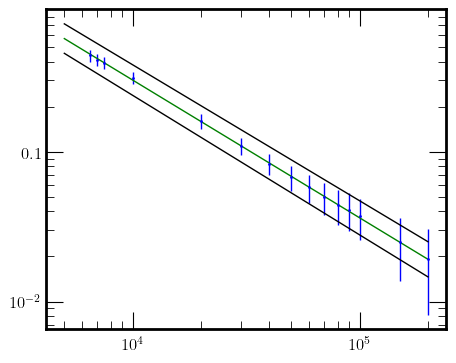

In [218]:
# Plot del fit di Bode
fig, axA = plt.subplots(1,1, figsize=(5,4))
axA.errorbar(f[f > 6e3], Tf[f > 6e3], yerr=sTf[f > 6e3], fmt='o', ms=1)

x_fit = np.linspace(5e3, max(f), 1000)

axA.plot(x_fit, 10**(retta(np.log10(x_fit), *valbode)/20), color = "g")
axA.plot(x_fit, 10**(retta(np.log10(x_fit), *(valbode+np.sqrt(np.diag(covbode))))/20), color = "k")
axA.plot(x_fit, 10**(retta(np.log10(x_fit), *(valbode-np.sqrt(np.diag(covbode))))/20), color = "k")


axA.loglog()

plt.show()

In [230]:
# Importo il file con solo i dati locali intorno della frequenza di taglio
data = pd.read_csv('Dati locali.txt', sep="\t")
floc = data["f"]/1000 #kHz
philoc = 2e-6 * np.pi * data["f"] * data["dT"] # in rapporto a 90°
sphiloc = 2e-6 * np.pi * data["f"] * np.sqrt(data["sT"]/(10*6**0.5))

Vin = 8.16 # V
sVin = np.sqrt((1/(25*24**0.5)))

Tfloc = data["Vch2"]/Vin
sTfloc = np.sqrt(((1/(25*24**0.5)) + (data["Vch2"]/Vin * sVin)**2))/Vin # Assumo triangolare



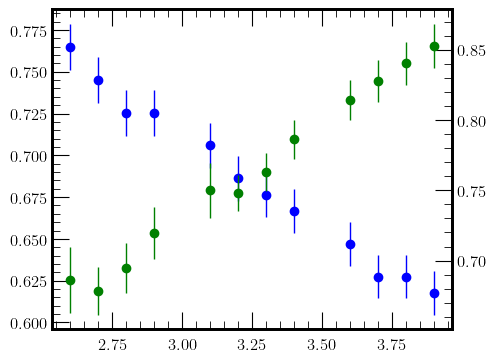

In [231]:
# Plot dei dati locali
fig, axA = plt.subplots(1,1, figsize=(5,4))
h = 0.15
axA.errorbar(floc, Tfloc, yerr=sTfloc, fmt='o')
axF = axA.twinx()
# axA.set_xlim(2400,4100)

axF.errorbar(floc, philoc,  yerr= sphiloc, fmt='o', color = 'green')

plt.show()

In [235]:
# Fit linearizzato della f. di trasferimento in un intorno della ft (freq. di taglio)
valtrlin, covtrlin = curve_fit(retta, floc, Tfloc, method='lm' ,sigma=sTfloc, absolute_sigma=True)

a,b = valtrlin

ft_tr_lin = (2**-0.5 - a)/b

print(ft_tr_lin,"+/-",s_ft_tr_lin, "kHz")

s_ft_tr_lin = np.sqrt((1/np.sqrt(2)-valtrlin[0])**2/valtrlin[1]**4*covtrlin[1,1]+1/valtrlin[1]**2*covtrlin[0,0]+2/valtrlin[1]**3*(1/np.sqrt(2)-valtrlin[0])*covtrlin[0,1])

residutrlin = Tfloc - retta(floc, *valtrlin)
chi2lintr = np.sum((residutrlin/Tfloc)**2)

df = len(floc)-2

print(chi2lintr/df)

3.0466701582731033 +/- 0.03954453049206063 kHz
6.089970535218982e-05


In [226]:
# Fit linearizzato della fase in un intorno della ft (freq. di taglio)
valphilin, covphilin = curve_fit(retta, floc, philoc, method='lm' ,sigma=sphiloc, absolute_sigma=True)

residuPhilin = Tfloc - retta(floc, *valtrlin)
chi2linPhi = np.sum((residuPhilin/sphiloc)**2)

df = len(floc)-2

print((np.pi/4 - valphilin[0])/valphilin[1])
print((valphilin[0]**2/valphilin[1]**4 * covphilin[1,1] + valphilin[1]**-2 * covphilin[0,0] + 2*valphilin[0]*valphilin[1]**-3 * covphilin[1,0])**0.5)

print(chi2linPhi/df)


3.415346422246687
0.10171844068285792
0.09873539937129348


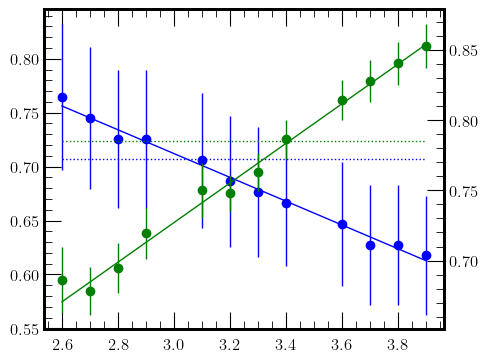

In [209]:
# Plot dei dati
fig, axA = plt.subplots(1,1, figsize=(5,4))
x_fit = np.linspace(min(floc),max(floc),100)
h = 0.1
axA.errorbar(floc, Tfloc, yerr=sTfloc, fmt='bo')
axA.plot(x_fit, retta(x_fit, *valtrlin), color = "b")

axA.plot(x_fit, np.full(len(x_fit), 2**-0.5), linestyle = "dotted")

axF = axA.twinx()
axF.plot(x_fit, retta(x_fit, *valphilin), color = "g")
axF.plot(x_fit, np.full(len(x_fit), np.pi/4), linestyle = "dotted", color = "g")

axF.errorbar(floc, philoc,  yerr= sphiloc, fmt='go')

plt.show()